In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

# Math Stuff
import ee, scipy.misc, random, os
import numpy as np
from threading import Thread

# debug stuff
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [2]:
# https://indico.io/blog/tensorflow-data-inputs-part1-placeholders-protobufs-queues/

# Machine Learning

In [3]:
import tensorflow as tf


from scipy import misc

def gee_batch(data_label_file, batch_size):
    """Generates batches of size `batch_size`"""
    
    # read file
    lines = open(data_label_file).read().splitlines()
    
    img_list = []
    label_list = []
    for i in range(batch_size):
        png_path, label = random.choice(lines).split(',')
        
        img = misc.imread(png_path)
        processed_img = img[:,:,0]
        small_img = scipy.misc.imresize(processed_img, (50,50))
#         three_d_img = np.expand_dims(small_img, axis=2)
        img_list.append(small_img.flatten() / 255.0)

        one_hot = np.zeros(3)
        one_hot[int(label)] = 1
        label_list.append(one_hot)
        
    return np.stack(img_list, axis=0), np.stack(label_list, axis=0)

In [9]:
#
# Create protobuf
#

DATA_DIR="./ch3_data"
TRAIN_IMG_DIR=os.path.join(DATA_DIR, "train_imgs")
TRAIN_IMG_LABELS=os.path.join(DATA_DIR, "train.txt")
TEST_IMG_DIR=os.path.join(DATA_DIR, "test_imgs")
TEST_IMG_LABELS=os.path.join(DATA_DIR, "test.txt")

PROTO_FILENAME = "gee_test.tfrecords"

# Open a protobuffer writer
proto_writer = tf.python_io.TFRecordWriter(PROTO_FILENAME)

# Iterate over every exmaple and put it in the protobuffer
for line in open(TEST_IMG_LABELS).read().splitlines():
    png_path, label = line.split(',')
    img = misc.imread(png_path).flatten()
    
    proto_example = tf.train.Example(
        features=tf.train.Features( # a map of string to Feature proto objects
            feature={
                # A Feature contains one of either a int64_list,
                # float_list, or bytes_list
                'label': tf.train.Feature(
                    int64_list=tf.train.Int64List(value=[int(label)])),
                'image': tf.train.Feature(
                    int64_list=tf.train.Int64List(value=img.astype("int64")))
            }
        )
    )
    
    # use the proto object to serialize the example to a string
    serialized = proto_example.SerializeToString()
    # write the serialized object to disk
    proto_writer.write(serialized)
    

0


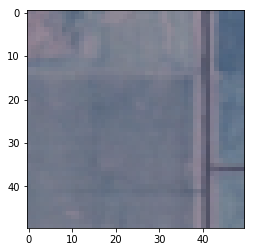

0


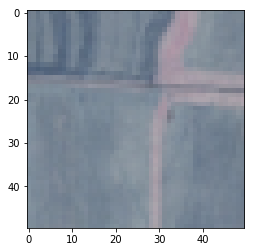

0


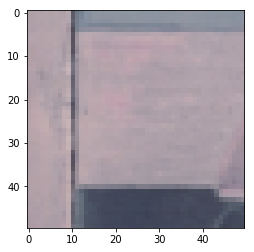

In [5]:
#
# Look inside protobuff to make sure records are correctly recorded.
#

PROTO_FILENAME = "gee_train.tfrecords"

i = 0
for serialized_example in tf.python_io.tf_record_iterator(PROTO_FILENAME):
    i = i + 1
    if i > 3:
        break
    example = tf.train.Example()
    example.ParseFromString(serialized_example)

    # traverse the Example format to get data
    image = example.features.feature['image'].int64_list.value
    label = example.features.feature['label'].int64_list.value[0]
    # do something
    print label

    img = np.array(image).astype("float32")

    plt.imshow(img.reshape((50,50, 3)), cmap='gray'); plt.show()


In [6]:
#
# Required input placeholders
#
proto_filename = tf.placeholder(tf.string) # Protobuf from which the network will draw
training = tf.placeholder(tf.bool) # True if training, False if testing

#
# Load the data tensors
#

filename_queue = tf.train.string_input_producer([proto_filename], num_epochs=None)
proto_reader = tf.TFRecordReader()

# Examples from the protobuf.
# TODO: what is the first returned value?
_, serialized_example = proto_reader.read(filename_queue)

# The serialized example is converted back to actual values
# by describing the format of the objects to be returned
features = tf.parse_single_example(
    serialized_example,
    features={
        # We know the length of both fields. If not the
        # tf.VarLenFeature could be used
        'label': tf.FixedLenFeature([], tf.int64),
        'image': tf.FixedLenFeature([50*50*3], tf.int64)
    })

# now we have the raw data
label = features['label']
image = features['image']

# wrest the data into the desired orientation
cast_img = tf.cast(image, tf.float32)
theeD_img = tf.reshape(cast_img, [50,50, 3])
bw_img = tf.slice(theeD_img, [0, 0, 0], [50, 50, 1])
oneD_img = tf.reshape(bw_img, [50*50])
squashed_img = tf.divide(oneD_img, 255)

# and batch it
images_batch, labels_batch = tf.train.shuffle_batch(
    [squashed_img, label], batch_size=128,
    capacity=2000,
    min_after_dequeue=1000)



#
# Model
#


x = images_batch
y_ = images_batch


input_norm = tf.contrib.layers.batch_norm(x, 
                                  center=True, scale=True, 
                                  is_training=training)



# Ensure our images are the correct shape
input_layer = tf.reshape(input_norm, [-1, 50, 50, 1])


#
# Convolutions
#

# Convolutional Layer #1
conv1 = tf.layers.conv2d(
    inputs=input_layer,
    filters=32,
    kernel_size=[4, 4],
    strides = [2,2],
    padding="valid",
    activation=tf.nn.relu)

# Convolutional Layer #2
conv2 = tf.layers.conv2d(
    inputs=conv1,
    filters=32,
    kernel_size=[4, 4],
    strides = [2,2],
    padding="valid",
    activation=tf.nn.relu)

# Convolutional Layer #3
conv3 = tf.layers.conv2d(
    inputs=conv2,
    filters=32,
    kernel_size=[3, 3],
    strides = [2,2],
    padding="valid",
    activation=tf.nn.relu)


# Dense Layer
conv3_flat = tf.reshape(conv3, [-1, 5 * 5 * 32])
fc1 = tf.layers.dense(inputs=conv3_flat, units=800, activation=tf.nn.relu)
fc2 = tf.layers.dense(inputs=fc1, units=800, activation=tf.nn.relu)
fc3 = tf.layers.dense(inputs=fc2, units=50*50, activation=tf.nn.relu)


#
# Loss
#

loss = None
train_op = None
y_pred = fc3
y_true = y_

loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))



In [7]:
#
# Train
#
from IPython.display import clear_output

DATA_DIR="./ch3_data"
TRAIN_IMG_DIR=os.path.join(DATA_DIR, "train_imgs")
TRAIN_IMG_LABELS=os.path.join(DATA_DIR, "train.txt")
TEST_IMG_DIR=os.path.join(DATA_DIR, "test_imgs")
TEST_IMG_LABELS=os.path.join(DATA_DIR, "test.txt")

TRAIN_PROTO_FILENAME = "gee_train.tfrecords"




update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # batch norm
with tf.control_dependencies(update_ops): # batch norm
    optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)


# Initialize tensorflow
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# start the data reader tensors
tf.train.start_queue_runners(sess=sess)

# And run 10k iterations
for i in range(10000):
    
    # Debug output
    if i%100 == 0:
        prediction, loss_out = sess.run( fetches = [y_pred, loss],
                                         feed_dict={proto_filename:"gee_train.tfrecords",
                                                    training: False})
        print i, ":", loss_out
    
    # run an iteration
    optimizer.run(feed_dict={proto_filename:"gee_train.tfrecords",
                             training: True})



0 : 0.243138
100 : 0.0407254
200 : 0.0320436
300 : 0.0351589
400 : 0.0331061
500 : 0.0281945
600 : 0.0234389
700 : 0.0337391
800 : 0.0192443
900 : 0.0238612
1000 : 0.0196609
1100 : 0.0229122
1200 : 0.0237258
1300 : 0.0223071
1400 : 0.0230942
1500 : 0.0207329
1600 : 0.0199087
1700 : 0.0175894
1800 : 0.0194344
1900 : 0.0147115
2000 : 0.018101
2100 : 0.0149598
2200 : 0.0152713
2300 : 0.0142166
2400 : 0.0157963
2500 : 0.0113491
2600 : 0.0129904
2700 : 0.0106544
2800 : 0.0122483
2900 : 0.00914005
3000 : 0.0100402
3100 : 0.00645088
3200 : 0.011248
3300 : 0.00669747
3400 : 0.00958061
3500 : 0.00693014
3600 : 0.00876049
3700 : 0.00619118
3800 : 0.00947576
3900 : 0.00560236
4000 : 0.00775708
4100 : 0.00520151
4200 : 0.00870176
4300 : 0.00568364
4400 : 0.00846311
4500 : 0.00427704
4600 : 0.00792142
4700 : 0.00451783
4800 : 0.00771073
4900 : 0.00449194
5000 : 0.00778919
5100 : 0.00418603
5200 : 0.00770191
5300 : 0.00452297
5400 : 0.00710904
5500 : 0.00538191
5600 : 0.00639293
5700 : 0.0076766
580

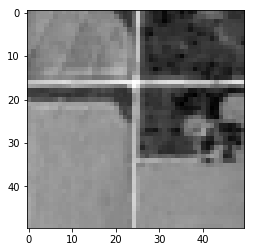

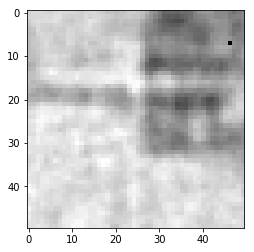

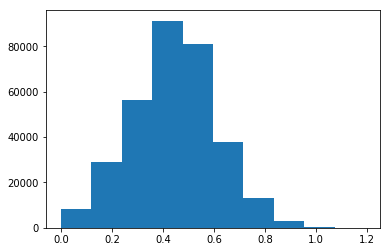

In [21]:
# Prediction

# farm, city, mountain


img_in, prediction, loss_out = sess.run( fetches = [y_true, y_pred, loss],
                                         feed_dict={proto_filename:"gee_test.tfrecords",
                                                    training: False})
    
plt.imshow(img_in.reshape((-1,50,50))[0,:,:], cmap='gray'); plt.show()
plt.imshow(prediction.reshape((-1, 50,50))[0,:,:], cmap='gray'); plt.show()
plt.hist(prediction.flatten()); plt.show()